# Predictive Analysis of Sea Surface Currents 'u'

This Notebook is an analysis and prediction of sea surface currents (SSC) using an LSTM Model. The primary focus is on processing, visualizing, and predicting based on historical sea surface current data. This pipeline aims to provide a comprehensive workflow from data processing to real-life future predictions, facilitating deeper insights into sea surface currents and their potential impacts.

## Overview
- **Data Preparation**: Loading and cleaning of time-series data from NetCDF files to create a structured dataset suitable for analysis.
- **Geospatial Visualization**: Mapping sea surface current data and identify areas of interest.
- **Data Filtering**: Narrowing down the dataset to focus on specific geographic regions and time frames for detailed analysis.
- **Predictive Modeling**: Developing LSTM models to forecast future sea surface current velocities based on historical data.
- **Evaluation**: Comparing predicted values against actual data to assess the accuracy and effectiveness of the models.
- **Output**: Aggregating all predictions and converting them into a format suitable for further analysis or integration into a Lagrangian Model.

### Import Necessary Libraries

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.models import load_model

### Suppressing Future Warnings


In [2]:
import warnings

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Importing & Opening the Data

Load and open the sea surface current dataset for subsequent analysis and modeling. This file has hourly data from 1st January 2020 till 1st August 2023

In [3]:
# Load the dataset
netcdf_file_path = "Data/model_IO/final_SSC_Data.nc"

# Open the dataset
dataset = xr.open_dataset(netcdf_file_path)

### Data Preparation 

1. **Conversion and Index Resetting**: The dataset is converted to a Pandas DataFrame and the index is reset.
2. **Column Removal**: Unnecessary columns ('stdu', 'stdv', 'cov', 'velo', 'head') that are not needed are removed.
3. **NaN Value Removal**: Rows containing NaN values in the 'u' and 'v' columns are removed.
4. **Datetime Conversion**: The 'time' column is converted to a datetime format.
5. **Display**: Finally, the cleaned DataFrame is displayed to verify the successful preprocessing steps.

In [4]:
# Convert the dataset to a pandas DataFrame and reset the index 
df = dataset.to_dataframe().reset_index()

# Drop unnecessary columns from the DataFrame that are not needed
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Drop rows with NaN values in 'u' and 'v' columns to ensure data integrity for analysis
df.dropna(subset=['u', 'v'],inplace=True)

# Convert the 'time' column to datetime format for time series analysis
df.index = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M:%S')

# Display the DataFrame
df

,time,lat,lon,u,v
time,,,,,
2020-02-25 15:00:00,2020-02-25 15:00:00,35.900600,14.5692,0.224436,-0.204129
2020-02-25 15:00:00,2020-02-25 15:00:00,35.900600,14.6097,0.225030,-0.220144
2020-02-25 15:00:00,2020-02-25 15:00:00,35.900600,14.6503,0.219380,-0.229340
2020-02-25 15:00:00,2020-02-25 15:00:00,35.900600,14.6908,0.192193,-0.223198
2020-02-25 15:00:00,2020-02-25 15:00:00,35.900600,15.0965,-0.088404,-0.160217
...,...,...,...,...,...
2023-08-01 23:00:00,2023-08-01 23:00:00,36.880199,14.0419,-0.179297,-0.109355
2023-08-01 23:00:00,2023-08-01 23:00:00,36.880199,14.0824,-0.187970,-0.150195
2023-08-01 23:00:00,2023-08-01 23:00:00,36.880199,14.1230,-0.184672,-0.175530


### Geospatial Visualization

- **Boundaries & Interest Area**: Set the coordinates dor the specific geographic boundaries and a polygon to highlight key area on the map.
- **Map Setup**: Initialize a map with features like land, coastlines, and borders for context.
- **Data Points**: Plot data points within the set boundaries to visualize the distribution of sea surface currents.
- **Highlight Area**: Draw a red polygon to emphasize the area of interest on the map.

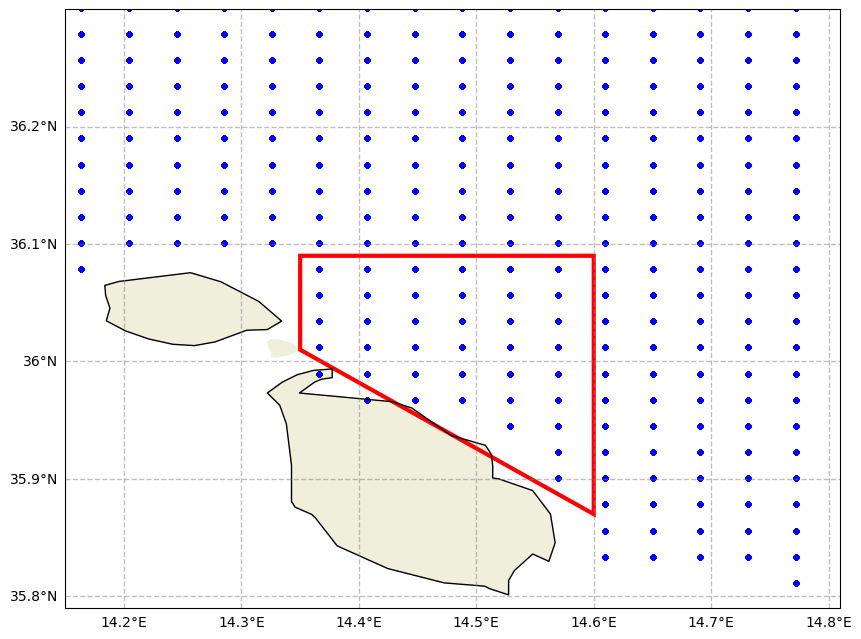

In [5]:
# Define the boundaries for the map 
boundaries = {
    'min_lon': 14.15,  
    'max_lon': 14.81,  
    'min_lat': 35.79,  
    'max_lat': 36.3    
}

# Define the vertices of a polygon to highlight a specific area on the map
polygon_coordinates = [
    (14.6, 35.87),
    (14.35, 36.01),
    (14.35, 36.09),
    (14.6, 36.09),
    (14.6, 35.87)
]

# Initialize a matplotlib figure with Cartopy for data visualization
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the viewing extent of the map using the defined boundaries
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add features to the map for land, coastlines, and country borders for context
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot all data points from the dataframe within the defined geographic boundaries
ax.scatter(df['lon'], df['lat'], s=10, color='blue', marker='o', alpha=0.5, transform=ccrs.Geodetic())

# Draw a red polygon using the defined coordinates to highlight a specific area on the map
red_polygon = mpatches.Polygon(polygon_coordinates, closed=True, edgecolor='red', facecolor='none', linewidth=3, transform=ccrs.Geodetic())
ax.add_patch(red_polygon)

# Add gridlines to the map
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Display the plot
plt.show()

### Geospatial Filtering

Filter the dataset to focus on the area of interest:

- **Filtering**: Apply the polygon as a filter to select only data points located inside this area.
- **Visualization**: Plot the filtered data on a map to visually confirm the focus area, marking points within the polygon in red for clarity.
- **Map Features**: Enhance the map with features like land, coastlines, and borders for better context.
- **Final View**: Display the map with the filtered points.

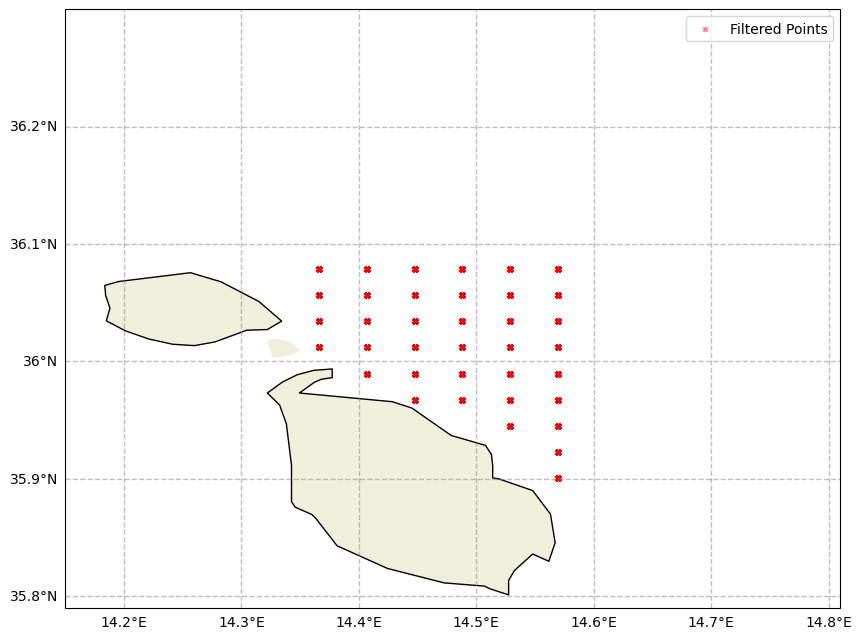

In [6]:
# Convert the list of polygon coordinates to a Path object
polygon_path = mpath.Path(polygon_coordinates)

# Use the Path object to filter points in the DataFrame that lie inside the polygon
inside_polygon = df.apply(lambda row: polygon_path.contains_point((row['lon'], row['lat'])), axis=1)
df_inside_polygon = df[inside_polygon]

# Initialize a new matplotlib figure with Cartopy for mapping, specifying the projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent of the map to the defined geographic boundaries
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add land, coastlines, and country borders to the map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the points that are located within the defined polygon in red
scatter = ax.scatter(df_inside_polygon['lon'], df_inside_polygon['lat'], s=10, color='red', marker='x', alpha=0.5, transform=ccrs.Geodetic(), label='Filtered Points')

# Add gridlines and labels to the map
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add a legend to the plot to explain the red "X" markers
ax.legend(handles=[scatter], loc='upper right')

# Display the plot
plt.show()

### Selecting the coordinates inside the polygon

Identify and processes data points located within the selected area:

- **Path Creation**: Transform the polygon coordinates into a Path object for spatial filtering.
- **Coordinate Pairing**: Combine 'lon' and 'lat' from the DataFrame into coordinate tuples.
- **Spatial Filtering**: Apply the Path object to select only points inside the polygon.
- **Duplicate Removal**: Eliminate duplicate points to ensure unique data entries.
- **Count and Display**: Calculate and print the total number of unique points inside the polygon, along with their coordinates.

In [7]:
# Convert the polygon coordinates to a Path object 
polygon_path = mpath.Path(polygon_coordinates)

# Combine longitude and latitude columns from the DataFrame into a list of tuples for each point
coordinates = list(zip(df['lon'], df['lat']))

# Create a mask to identify which points fall within the defined polygon by checking each point
inside_mask = [polygon_path.contains_point(coord) for coord in coordinates]

# Use the mask to filter the DataFrame, keeping only points that are inside the polygon
df_inside_polygon = df[inside_mask]

# Remove potential duplicate entries based on their longitude and latitude
df_inside_polygon = df_inside_polygon.drop_duplicates(subset=['lon', 'lat'])

# Calculate the number of unique points found inside the polygon
num_points_inside_polygon = df_inside_polygon.shape[0]
print(f"Total number of points inside the polygon: {num_points_inside_polygon}\n")
print("Coordinates of the points inside the polygon:")

# Iterate over each coordinate pair inside the polygon and print them out
coordinates_inside = df_inside_polygon[['lon', 'lat']].values
for lon, lat in coordinates_inside:
    print(f"({lon}, {lat})")

Total number of points inside the polygon: 37

Coordinates of the points inside the polygon:
(14.569199562072754, 35.90060043334961)
(14.569199562072754, 35.92279815673828)
(14.569199562072754, 35.945098876953125)
(14.528599739074707, 35.96730041503906)
(14.569199562072754, 35.96730041503906)
(14.447500228881836, 35.989601135253906)
(14.48799991607666, 35.989601135253906)
(14.528599739074707, 35.989601135253906)
(14.569199562072754, 35.989601135253906)
(14.447500228881836, 36.01190185546875)
(14.48799991607666, 36.01190185546875)
(14.528599739074707, 36.01190185546875)
(14.569199562072754, 36.01190185546875)
(14.447500228881836, 36.03409957885742)
(14.48799991607666, 36.03409957885742)
(14.528599739074707, 36.03409957885742)
(14.569199562072754, 36.03409957885742)
(14.447500228881836, 36.056400299072266)
(14.48799991607666, 36.056400299072266)
(14.528599739074707, 36.056400299072266)
(14.569199562072754, 36.056400299072266)
(14.366399765014648, 36.07870101928711)
(14.406900405883789, 3

### Create a Data Frame for the coordinates inside the polygon

In [8]:
# Convert 'inside_mask' to a pandas Series to use as a boolean indexer
inside_series = pd.Series(inside_mask, index=df.index)

# Filter the original DataFrame using the boolean Series
final_df = df[inside_series]

# Display the final DataFrame
final_df

,time,lat,lon,u,v
time,,,,,
2020-02-25 15:00:00,2020-02-25 15:00:00,35.900600,14.5692,0.224436,-0.204129
2020-02-25 15:00:00,2020-02-25 15:00:00,35.922798,14.5692,0.209744,-0.180382
2020-02-25 15:00:00,2020-02-25 15:00:00,35.945099,14.5692,0.165433,-0.158304
2020-02-25 15:00:00,2020-02-25 15:00:00,35.967300,14.5286,0.139062,-0.155931
2020-02-25 15:00:00,2020-02-25 15:00:00,35.967300,14.5692,0.162474,-0.140758
...,...,...,...,...,...
2023-08-01 23:00:00,2023-08-01 23:00:00,36.078701,14.4069,0.148599,-0.234722
2023-08-01 23:00:00,2023-08-01 23:00:00,36.078701,14.4475,0.153244,-0.216512
2023-08-01 23:00:00,2023-08-01 23:00:00,36.078701,14.4880,0.165081,-0.183771


### Data Extraction for Selected Coordinates

Extracting and saving specific sea surface current data for predefined locations within our area of interest:

- **Selected Coordinates**: List the specific latitude and longitude pairs.
- **Data Extraction**: For each pair, filter the main dataset to obtain the relevant data points.
- **File Saving**: Convert latitude and longitude to a format suitable for filenames and save the data as CSV files.

Each data point's latitude and longitude are converted to remove decimal points, ensuring valid filenames. This process results in a set of CSV files, each corresponding to a unique location within the selected polygon.

In [9]:
# Directory to save the files
save_directory = "Data/coordinate_data_frames"
os.makedirs(save_directory, exist_ok=True)

# Coordinates of the points inside the polygon
coordinates_inside = [
    (14.569199562072754, 35.90060043334961),
    (14.569199562072754, 35.92279815673828),
    # (14.569199562072754, 35.945098876953125),
    # (14.528599739074707, 35.96730041503906),
    # (14.569199562072754, 35.96730041503906),
    # (14.447500228881836, 35.989601135253906),
    # (14.48799991607666, 35.989601135253906),
    # (14.528599739074707, 35.989601135253906),
    # (14.569199562072754, 35.989601135253906),
    # (14.447500228881836, 36.01190185546875),
    # (14.48799991607666, 36.01190185546875),
    # (14.528599739074707, 36.01190185546875),
    # (14.569199562072754, 36.01190185546875),
    # (14.447500228881836, 36.03409957885742),
    # (14.48799991607666, 36.03409957885742),
    # (14.528599739074707, 36.03409957885742),
    # (14.569199562072754, 36.03409957885742),
    # (14.447500228881836, 36.056400299072266),
    # (14.48799991607666, 36.056400299072266),
    # (14.528599739074707, 36.056400299072266),
    # (14.569199562072754, 36.056400299072266),
    # (14.366399765014648, 36.07870101928711),
    # (14.406900405883789, 36.07870101928711),
    # (14.447500228881836, 36.07870101928711),
    # (14.48799991607666, 36.07870101928711),
    # (14.528599739074707, 36.07870101928711),
    # (14.569199562072754, 36.07870101928711),
    # (14.528599739074707, 35.945098876953125),
    # (14.406900405883789, 36.03409957885742),
    # (14.406900405883789, 36.056400299072266),
    # (14.406900405883789, 36.01190185546875),
    # (14.366399765014648, 36.03409957885742),
    # (14.366399765014648, 36.056400299072266),
    # (14.48799991607666, 35.96730041503906),
    # (14.406900405883789, 35.989601135253906,),
    # (14.366399765014648, 36.01190185546875),
    # (14.447500228881836, 35.96730041503906)
]

# Loop through each pair of coordinates along with an index
for index, (lon, lat) in enumerate(coordinates_inside, start=1):
    # Print the current pair being processed
    print(f"Processing pair {index}: (lat: {lat}, lon: {lon})")

    # Filter the DataFrame for the exact coordinates
    df_point = final_df[(final_df['lat'] == lat) & (final_df['lon'] == lon)]

    # Check if any data points were found for the current pair
    if df_point.empty:
        print(f"No data points found for (lat: {lat}, lon: {lon})")
    else:
        print(f"Found {df_point.shape[0]} data points for (lat: {lat}, lon: {lon})")

    # Format the latitude and longitude to remove decimal points and replace with underscores
    lat_formatted = str(lat).replace('.', '_')
    lon_formatted = str(lon).replace('.', '_')

    # Create a unique filename for each pair of coordinates
    filename = f"{index}_{lat_formatted}_{lon_formatted}.csv"
    filepath = os.path.join(save_directory, filename)

    # Save the filtered DataFrame to a CSV file
    df_point.to_csv(filepath, index=False)

    # Confirm that the file has been saved
    print(f"Saved data for (lat: {lat}, lon: {lon}) as {filename}\n")

print("All data processing complete.")
print("="*175)

Processing pair 1: (lat: 35.90060043334961, lon: 14.569199562072754)
Found 6694 data points for (lat: 35.90060043334961, lon: 14.569199562072754)
Saved data for (lat: 35.90060043334961, lon: 14.569199562072754) as 1_35_90060043334961_14_569199562072754.csv

Processing pair 2: (lat: 35.92279815673828, lon: 14.569199562072754)
Found 6804 data points for (lat: 35.92279815673828, lon: 14.569199562072754)
Saved data for (lat: 35.92279815673828, lon: 14.569199562072754) as 2_35_92279815673828_14_569199562072754.csv

All data processing complete.


### Model Preparation, Training & Evaluation

- **Model Storage**: Set up a directory to save the trained models.
- **Data Preparation**: List and load all coordinate-specific CSV files that were prepared earlier.
- **Feature Selection**: For each dataset, 'u' and 'v' values are chosen as features with 'u' set as the target variable.
- **Time Series Generation**: Construct time series generators, utilizing the last 72 hours (3 days) of data to predict the 'u' value for the next hour. This historical data frame helps the model understand temporal patterns.
- **Early Stopping**: Integrate early stopping to halt training when the validation loss stops improving, preventing overfitting and saving computational resources.
- **Model Architecture**: Build the LSTM (Long Short-Term Memory) network. The model architecture includes several layers with dropout rates to manage overfitting.
- **Training Process**: Train the model on the generated time series data, monitoring both training and validation metrics.
- **Prediction and Evaluation**:
    - **Prediction**: After training, apply the model to the test set to forecast future 'u' values.
    - **Evaluation Metrics**: Use three key metrics to evaluate model performance:
        - **Mean Squared Error (MSE)**: Represents the average of the squares of the errors between actual and predicted values. Lower values indicate better performance.
        - **Mean Absolute Error (MAE)**: Measures the average magnitude of errors between pairs of actual and predicted values, without considering their direction. Lower MAE values signify better accuracy.
        - **Root Mean Squared Error (RMSE)**: The square root of MSE, providing error metrics in the same units as the data, making interpretation straightforward. Lower RMSE values denote better fit.
    - **Visualization**: Plot actual vs. predicted 'u' values to visually assess the model's prediction accuracy and understand its real-world applicability.

Processing file: 1_35_90060043334961_14_569199562072754.csv

73/73 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0805INFO:tensorflow:Assets written to: Data/saved_models\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 31s 390ms/step - loss: 0.0104 - mean_absolute_error: 0.0805 - val_loss: 0.0110 - val_mean_absolute_error: 0.0796
Training stopped at epoch: -2
Best validation loss achieved at epoch: -2



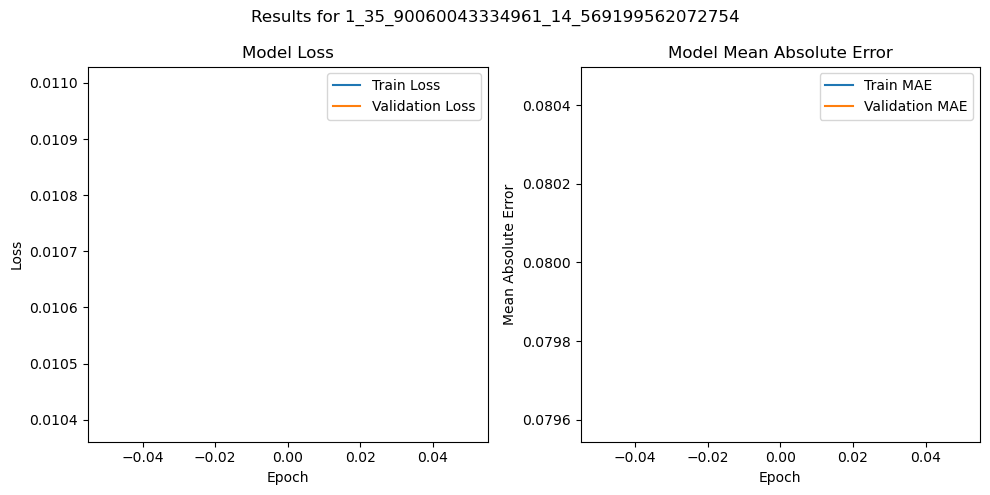

15/15 [==============================] - 2s 67ms/step

File: 1_35_90060043334961_14_569199562072754
Mean Squared Error (MSE): 0.008105914341659791
Mean Absolute Error (MAE): 0.07234011157626759
Root Mean Squared Error (RMSE): 0.09003285145800832


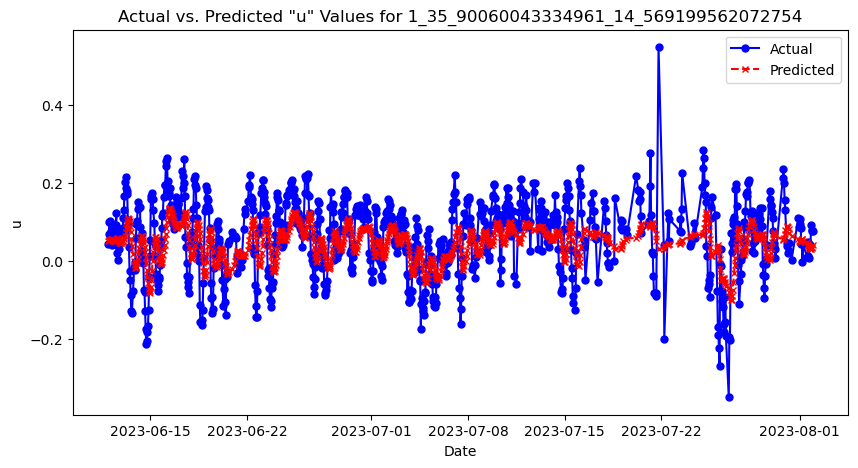

Model tarining & evaluation completed for file: 1_35_90060043334961_14_569199562072754.csv

Processing file: 2_35_92279815673828_14_569199562072754.csv

74/74 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0811INFO:tensorflow:Assets written to: Data/saved_models\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 31s 390ms/step - loss: 0.0104 - mean_absolute_error: 0.0811 - val_loss: 0.0110 - val_mean_absolute_error: 0.0808
Training stopped at epoch: -2
Best validation loss achieved at epoch: -2



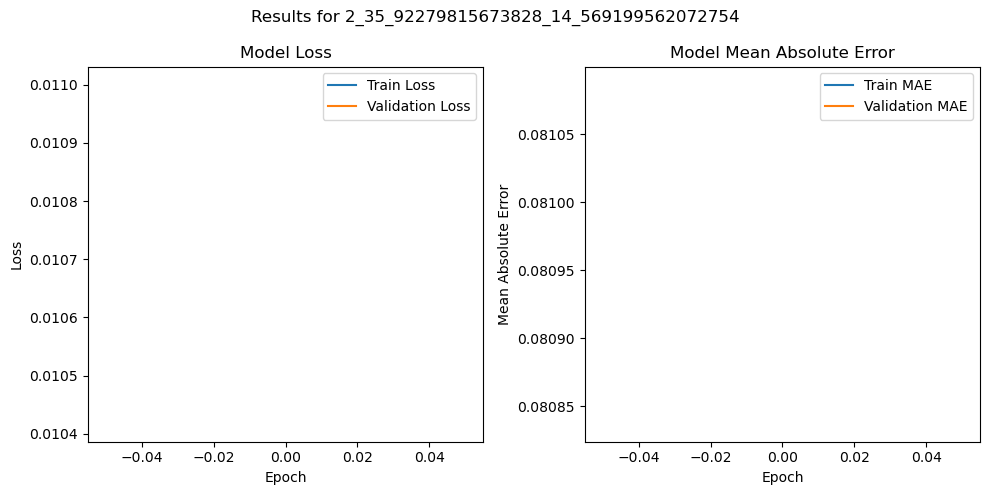

15/15 [==============================] - 2s 69ms/step

File: 2_35_92279815673828_14_569199562072754
Mean Squared Error (MSE): 0.006883991541786716
Mean Absolute Error (MAE): 0.0668343128638541
Root Mean Squared Error (RMSE): 0.08296982307915762


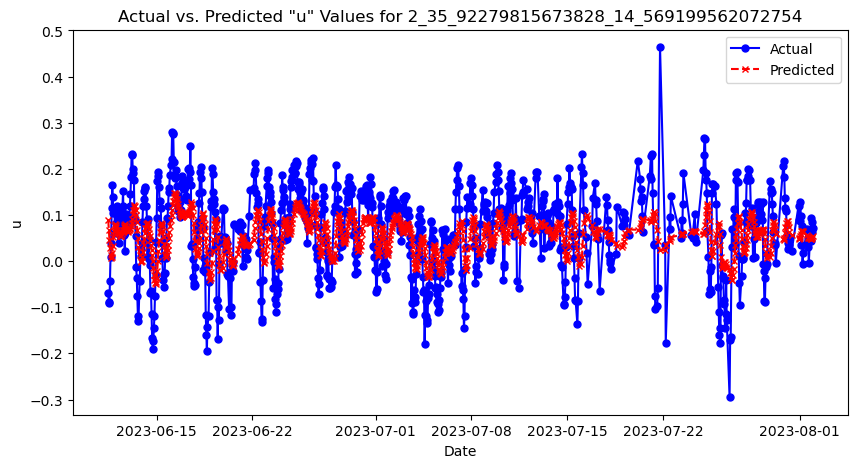

Model tarining & evaluation completed for file: 2_35_92279815673828_14_569199562072754.csv



In [10]:
# Directory for saving models 
model_save_directory = "Data/saved_models"
os.makedirs(model_save_directory, exist_ok=True)

# List all CSV files in the directory 
csv_files = [f for f in os.listdir(save_directory) if f.endswith('.csv')]

# Set up early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

# Loop through each CSV file in the directory
for file in csv_files:
    print("="*175)
    print(f"Processing file: {file}\n")

    # Load the dataset from the CSV file
    df = pd.read_csv(os.path.join(save_directory, file))

    # Convert the 'time' column to datetime object and set it as the index 
    df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)
    df.set_index('time', inplace=True)

    # Select 'u' and 'v' columns as input features 
    df_input = df[['u', 'v']]
    features = df_input.to_numpy()

    # Set the 'u' column as the target variable 
    target = df_input['u'].values

    # Splitting Data into Train, Validation, and Test sets (70-15-15 split)
    X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=123, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123, shuffle=False)

    # Time series generator parameters
    win_length = 72 # 3 Days
    batch_size = 64 # 64 samples per batch
    num_features = 2 # 'u' and 'v' columns

    # Creating the time series generators for the training, validation, and test sets
    train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
    val_generator = TimeseriesGenerator(X_val, y_val, length=win_length, sampling_rate=1, batch_size=batch_size)
    test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

    # Building the LSTM Model Architecture
    model = Sequential([
        LSTM(256, input_shape=(win_length, num_features), return_sequences=True),
        Dropout(0.3),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])

    # Compile the model 
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[MeanAbsoluteError()])

    # Define ModelCheckpoint callback to save the best model during training
    model_checkpoint = ModelCheckpoint(filepath=f"{model_save_directory}/{file[:-4]}", save_best_only=True, monitor='val_loss', mode='min', verbose=0, save_format='tf')

    # Fit the model to the training data
    history = model.fit(train_generator, epochs=1, validation_data=val_generator, shuffle=False, callbacks=[early_stopping, model_checkpoint])

    # Determine the epoch number at best performance
    best_epoch = early_stopping.stopped_epoch - early_stopping.patience

    # Print the best epoch number and the best validation loss achieved
    print("="*175)
    print(f"Training stopped at epoch: {best_epoch + 1}")
    print(f"Best validation loss achieved at epoch: {best_epoch + 1}\n")

    # Plot training and validation loss values 
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot training and validation mean absolute error values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Train MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Display the plots 
    plt.suptitle(f'Results for {file[:-4]}')
    plt.tight_layout()
    plt.show()

    # Generate predictions for the test data 
    predictions = model.predict(test_generator)
    test_indexes = df.index[-len(predictions):]

    # Prepare the final DataFrame for plotting and analysis 
    df_final = pd.DataFrame(df.loc[test_indexes])
    df_final['u_pred'] = predictions.flatten()

    # Calculate evaluation metrics  
    mse = mean_squared_error(df_final['u'], df_final['u_pred'])
    mae = mean_absolute_error(df_final['u'], df_final['u_pred'])
    rmse = np.sqrt(mse)

    # Print evaluation metrics
    print(f'\nTest set Evaluation metrics for file: {file[:-4]}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Root Mean Squared Error (RMSE): {rmse}\n')

    # Plot Actual vs. Predicted 'u' Values
    plt.figure(figsize=(10, 5))
    plt.plot(df_final.index, df_final['u'], label='Actual', color='blue', marker='o', linestyle='-', markersize=5)
    plt.plot(df_final.index, df_final['u_pred'], label='Predicted', color='red', marker='x', linestyle='--', markersize=5)
    plt.title(f'Actual vs. Predicted "u" Values for {file[:-4]}')  
    plt.xlabel('Date') 
    plt.ylabel('u')
    plt.legend()
    plt.show()
    
    print("="*175)
    print(f"Model tarining & evaluation completed for file: {file}")
    print("="*175, "\n")

## Making Real-life Predictions from Data (Simulation)
This section outlines the process of making predictions based on real-life data collected over a span of three days. The goal is to use data from the previous three days to simulate a prediction of the sea surface currents for the 4th of August, demonstrating the application in real-world scenarios.

### Extract 3 Days of Inputs for Each Coordinate Pair

- **Data Loading**: Retrieve sea surface current data from August 1, 2023, to August 3, 2023, and load it.
- **Dataframe Conversion**: Transform the loaded NetCDF data into a pandas DataFrame.
- **Data Cleaning**: Remove unnecessary columns.
- **Data Organization**: Set up a directory specifically for storing the processed data files.
- **Data Processing**:
    - For each predefined pair of coordinates, isolate the data corresponding to that location.
    - Ensure the data is in order to maintain the sequence integrity.
    - Apply cubic spline interpolation to fill in any missing 'u' and 'v' values, ensuring a continuous dataset.
- **File Saving**: Format latitude and longitude information for compatibility with filenames and save the individual data frames as seperate CSV files. Each file is uniquely named to correspond with its geographic location.

In [11]:
# Load the dataset (from August 1, 2023 till August 3, 2023) 
input_netcdf_path = "Data/model_IO/3_day_input_SSC_Data.nc"
dataset = xr.open_dataset(input_netcdf_path)

# Convert the dataset to a pandas DataFrame and reset the index
df = dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame that are not needed
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Directory to save the files 
input_data_directory = "Data/3_day_input_data_frames"
os.makedirs(input_data_directory, exist_ok=True)

# Loop through each pair of coordinates 
for index, (lon, lat) in enumerate(coordinates_inside, start=1):
    # Extract data for the specific coordinates and copy it
    df_specific = df[(df['lat'] == lat) & (df['lon'] == lon)].copy()

    # Ensure the DataFrame is sorted by time 
    df_specific.sort_values('time', inplace=True)

    # Interpolate NaN values using cubic spline interpolation
    df_specific.loc[:, ['u', 'v']] = df_specific[['u', 'v']].interpolate(method='spline', order=3)

    # After interpolation, if there are still NaNs at the beginning or the end, fill them in using the nearest value
    df_specific.loc[:, ['u', 'v']] = df_specific[['u', 'v']].fillna(method='bfill').fillna(method='ffill')

    # Replace decimal points with underscores in lat and lon for the filename
    lat_str = str(lat).replace('.', '_')
    lon_str = str(lon).replace('.', '_')

    # Save to CSV file with a unique filename
    filename = f"{index}_{lat_str}_{lon_str}_3_day.csv"
    filepath = os.path.join(input_data_directory, filename)
    df_specific.to_csv(filepath, index=False)
    print(f"Saved 3-day data for (lat: {lat}, lon: {lon}) as {filename}")
    
print("="*175)

Saved 3-day data for (lat: 35.90060043334961, lon: 14.569199562072754) as 1_35_90060043334961_14_569199562072754_3_day.csv
Saved 3-day data for (lat: 35.92279815673828, lon: 14.569199562072754) as 2_35_92279815673828_14_569199562072754_3_day.csv


### Extract 1 day of actaul data for each coordinate pair to use for comparison 

- **Data Loading**: Access actual sea surface current data for August 4th, 2023, to compare against the predictions.
- **Dataframe Conversion**: Transform the NetCDF data into a pandas DataFrame.
- **Data Cleaning**: Remove unnecessary columns.
- **File Organization**: Establish a directory specifically for storing actual data files.
- **Data Processing**:
    - For each predefined pair of coordinates, isolate the data corresponding to that location.
    - Sort this data to maintain the correct time sequence.
    - Fill in missing 'u' and 'v' data points using cubic spline interpolation.
- **File Saving**: Adjust latitude and longitude information for filename compatibility and save the processed data frames as seperate CSV files. Each file is distinctly named according to its geographic location.

In [12]:
# Load the dataset for the next day (August 4th, 2023) 
actual_netcdf_path = "Data/model_IO/1_day_actual_4th_SSC_Data.nc"
actual_dataset = xr.open_dataset(actual_netcdf_path)

# Convert the dataset to a pandas DataFrame and reset index
actual_df = actual_dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame that are not needed
actual_df = actual_df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Directory to save the files
actual_data_directory = "Data/1_day_actual_data_frames"
os.makedirs(actual_data_directory, exist_ok=True)

# Loop through each pair of coordinates
for index, (lon, lat) in enumerate(coordinates_inside, start=1):
    # Extract data for the specific coordinates and copy it
    actual_df_specific = actual_df[(actual_df['lat'] == lat) & (actual_df['lon'] == lon)].copy()

    # Ensure the DataFrame is sorted by time
    actual_df_specific.sort_values('time', inplace=True)

    # Interpolate NaN values using cubic spline interpolation
    actual_df_specific.loc[:, ['u', 'v']] = actual_df_specific[['u', 'v']].interpolate(method='spline', order=3)

    # After interpolation, if there are still NaNs at the beginning or the end, fill them in using the nearest value
    actual_df_specific.loc[:, ['u', 'v']] = actual_df_specific[['u', 'v']].fillna(method='bfill').fillna(method='ffill')

    # Replace decimal points with underscores in lat and lon for the filename
    lat_str = str(lat).replace('.', '_')
    lon_str = str(lon).replace('.', '_')

    # Save to CSV file with a unique filename
    filename = f"{index}_{lat_str}_{lon_str}_1_day.csv"
    filepath = os.path.join(actual_data_directory, filename)
    actual_df_specific.to_csv(filepath, index=False)
    print(f"Saved 1-day actual data for (lat: {lat}, lon: {lon}) as {filename}")

print("="*175)

Saved 1-day actual data for (lat: 35.90060043334961, lon: 14.569199562072754) as 1_35_90060043334961_14_569199562072754_1_day.csv
Saved 1-day actual data for (lat: 35.92279815673828, lon: 14.569199562072754) as 2_35_92279815673828_14_569199562072754_1_day.csv


### Rolling Prediction for 24 hours

This section performs a series of rolling predictions, for a total of 24 hours, utilizing the previously trained models. 

- **Prediction Initialization**: Begin with an empty list to store outcomes from all models.
- **Prediction Span**: Set the forecast length to 24 hours (1 day).
- **Model Access**: Locate all saved LSTM models from the designated storage directory.
- **Iterative Forecasting**: For each saved model:
    - Retrieve the model's unique identifier.
    - Load the LSTM model.
    - Prepare input data derived from the preceding three days corresponding to each geographical location.
    - Execute sequential predictions where each hourly prediction informs the next, mirroring real-world forecasting scenarios. Specifically:
        - Utilize the model to forecast the next 'u' value based on the last 72 hours (3 days) of data.
        - Update the input feature set for the subsequent prediction by appending the newly predicted 'u' value while shifting the dataset forward by one hour, ensuring the model consistently receives fresh data reflecting the most recent conditions.
        - Importantly, while 'u' values are iteratively forecasted and updated, the 'v' values are directly drawn from the actual data for the corresponding hour, maintaining the model's contextual relevance to evolving environmental conditions.
- **Data Synchronization**: Align each prediction with actual data to evaluate the model's performance accurately.
    - Preprocess real data to match the model's input structure.
    - Record every hourly forecast alongside actual measurements for comparison.
- **Performance Metrics**: For each model, compute and report key metrics:
    - **MAE (Mean Absolute Error)**: Reflects the average magnitude of errors between predicted and actual values, irrespective of direction.
    - **MSE (Mean Squared Error)**: Emphasizes larger errors by squaring them, thus penalizing more significant discrepancies more severely.
    - **RMSE (Root Mean Squared Error)**: Provides error magnitude in the same units as the predicted values.
- **Result Compilation**: Aggregate all hourly predictions across all models and locations into a single DataFrame, creating a comprehensive overview of the forecasting performance.
- **Save Predictions**: Store the combined predictions as a CSV file.

In [13]:
# Initialize a list to collect the results of all predictions
all_predictions = []

# Number of hours to predict into the future
n_future_hours = 24  

# Specify the directory where saved models are stored
model_directory = "Data/saved_models"

# Retrieve paths for all saved models within the specified directory 
model_paths = [os.path.join(model_directory, filename).replace("\\", "/") for filename in os.listdir(model_directory)]

# Iterate over each model to perform predictions
for model_path in model_paths:
    # Extract model identifier from the file name
    model_id = os.path.basename(model_path).split('.')[0]  
    
    print("="*175)
    print(f"Processing model: {model_id}")
    print("="*175, "\n")

    # Load the saved model from its path
    model = tf.keras.models.load_model(model_path)

    # Define paths for input data and actual comparison data
    input_data_path = os.path.join(input_data_directory, f"{model_id}_3_day.csv").replace("\\", "/")
    actual_data_path = os.path.join(actual_data_directory, f"{model_id}_1_day.csv").replace("\\", "/")

    # Load and preprocess input data from CSV file
    input_data_df = pd.read_csv(input_data_path)
    input_data_df['time'] = pd.to_datetime(input_data_df['time'])
    features = input_data_df[['u', 'v']].values[-win_length:].reshape(1, win_length, num_features)

    # Initialize a list to store predictions for each hour
    predictions_u = []
    # Perform rolling predictions for the defined number of future hours
    for i in range(n_future_hours):
        # Predict the next value using the model
        current_prediction_u = model.predict(features, verbose=0)[0, 0]
        # Append the prediction to the list
        predictions_u.append(current_prediction_u)
        # Update the features for the next prediction step
        next_v_values = np.roll(features[0, :, 1], -1)
        # Use the most recent 'v' value
        next_v_values[-1] = features[0, -1, 1]  
        features = np.column_stack((np.roll(features[0, :, 0], -1), next_v_values)).reshape(1, win_length, num_features)
        # Set the last 'u' value to the current prediction
        features[0, -1, 0] = current_prediction_u  

    # Load and preprocess actual data for comparison
    actual_data_df = pd.read_csv(actual_data_path)
    actual_data_df['time'] = pd.to_datetime(actual_data_df['time'])
    actual_u_values = actual_data_df['u'].values[:n_future_hours]
    # Use the first row's lat and lon for location
    lat, lon = actual_data_df[['lat', 'lon']].values[0]  

    # Compile all predictions with their corresponding timestamps and locations
    for i, predicted_u in enumerate(predictions_u):
        all_predictions.append([actual_data_df['time'].iloc[i], lat, lon, predicted_u])

    # Calculate evaluation metrics 
    mae = mean_absolute_error(actual_u_values, predictions_u)
    mse = mean_squared_error(actual_u_values, predictions_u)
    rmse = np.sqrt(mse)

    # Display calculated metrics
    print(f"Metrics for model {model_id}:\nMAE = {mae}\nMSE = {mse}\nRMSE = {rmse}\n")

print("="*175)

# Convert the list of all predictions into a DataFrame
predictions_df = pd.DataFrame(all_predictions, columns=['time', 'lat', 'lon', 'u'])

# Save the compiled predictions to a CSV file
predictions_df.to_csv("Data/model_IO/merged_predictions.csv", index=False)
print("Saved merged predictions to 'Data/model_IO/merged_predictions.csv'")
print("="*175)

Processing model: 1_35_90060043334961_14_569199562072754

Metrics for model 1_35_90060043334961_14_569199562072754:
MAE = 0.09151025435258471
MSE = 0.009804821530910824
RMSE = 0.09901929878014096

Processing model: 2_35_92279815673828_14_569199562072754

Metrics for model 2_35_92279815673828_14_569199562072754:
MAE = 0.15376579357143705
MSE = 0.025524895881208043
RMSE = 0.1597651272374796

Saved merged predictions to 'Data/model_IO/merged_predictions.csv'


### Convert Merged Predictions from CSV to NetCDF format for Use in Lagrangian Model

In [15]:
# Read the saved predictions file from CSV format into a pandas DataFrame
merged_predictions_path = "Data/model_IO/merged_predictions.csv"
merged_predictions_df = pd.read_csv(merged_predictions_path)

# Convert the 'time' column from string to datetime format
merged_predictions_df['time'] = pd.to_datetime(merged_predictions_df['time'])
# Set ['time', 'lat', 'lon'] as the multi-level index for the xarray Dataset
xr_dataset = xr.Dataset.from_dataframe(merged_predictions_df.set_index(['time', 'lat', 'lon']))

# Convert the xarray Dataset to NetCDF format
netcdf_output_path = "Data/model_IO/merged_predictions.nc"
xr_dataset.to_netcdf(netcdf_output_path)
print(f"Saved merged predictions to '{netcdf_output_path}'")

Saved merged predictions to 'Data/model_IO/merged_predictions.nc'


---